In [193]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import SatelliteDynamics
from utils import get_form_initial_conditions

generate_random_graph = False
maximize_independent_C_nodes = False

In [194]:
def sqrtm(A):
    """
    Compute the square root of a symmetric matrix A using eigenvalue decomposition.

    Parameters:
        A (numpy.ndarray): A symmetric matrix of shape (n, n).

    Returns:
        numpy.ndarray: The square root of the matrix A, A^(1/2).
    """
    if not np.allclose(A, A.T):
        raise ValueError("Matrix A is not symmetric.")
    
    # Perform eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    
    # Check if all eigenvalues are non-negative
    if np.any(eigenvalues < 0):
        raise ValueError("Matrix A has negative eigenvalues and cannot have a real square root.")
    
    # Compute the square root of the eigenvalues
    sqrt_eigenvalues = np.sqrt(eigenvalues)
    
    # Reconstruct A^(1/2)
    A_sqrt = eigenvectors @ np.diag(sqrt_eigenvalues) @ eigenvectors.T
    
    return A_sqrt

def invsqrtm(A):
    return np.linalg.inv(sqrtm(A))

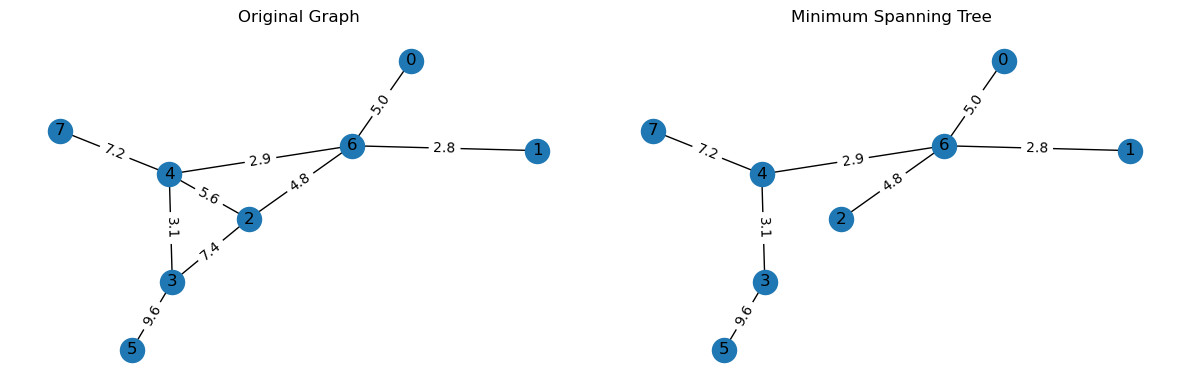

In [195]:
number_of_nodes = 8
number_of_edges = 9

if generate_random_graph:
    # Generate a random graph
    G = nx.gnm_random_graph(number_of_nodes, number_of_edges)
    
    # Ensure the graph is connected
    while not nx.is_connected(G):
        # Find connected components
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            node_from_prev = list(components[i - 1])[0]
            node_from_curr = list(components[i])[0]
            G.add_edge(node_from_prev, node_from_curr)
            
    # Add random weights to the edges
    for (u, v) in G.edges():
        # Only with one decimal place
        G[u][v]['weight'] = round(np.random.uniform(0.1, 10), 1)
else:
    # Define the graph
    edges_with_weights = [
        (0, 6, 5.0),
        (1, 6, 2.8),
        (6, 4, 2.9),
        (6, 2, 4.8),
        (2, 4, 5.6),
        (4, 3, 3.1),
        (4, 7, 7.2),
        (3, 5, 9.6),
        (3, 2, 7.4)
    ]

    # Create the graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges_with_weights)
        
# Compute the layout for the graph
pos = nx.spring_layout(G)

# Compute the Minimum Spanning Tree (MST) using NetworkX's API
MST = nx.minimum_spanning_tree(G, weight='weight')

# Visualize the graph and MST in 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the original graph
plt.sca(axes[0])
nx.draw(G, pos, with_labels=True, ax=axes[0])
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[0])
axes[0].set_title("Original Graph")

# Plot the Minimum Spanning Tree
plt.sca(axes[1])
nx.draw(MST, pos, with_labels=True, ax=axes[1])
edge_labels = nx.get_edge_attributes(MST, 'weight')
nx.draw_networkx_edge_labels(MST, pos, edge_labels=edge_labels, ax=axes[1])
axes[1].set_title("Minimum Spanning Tree")

plt.tight_layout()
plt.show()

In [196]:
# Compute parent and children relationships for the MST
parent_children = {}

# Use a Depth-First Search (DFS) to extract parent-child relationships
for edge in nx.dfs_edges(MST):
    parent, child = edge
    # Add child to parent's list
    if parent not in parent_children:
        parent_children[parent] = {'children': [], 'parent': None}
    if child not in parent_children:
        parent_children[child] = {'children': [], 'parent': None}
    parent_children[parent]['children'].append(child)
    # Set child's parent
    parent_children[child]['parent'] = parent

# Display the parent-children relationships
node_relationships = {
    node: {
        "parent": relationships["parent"],
        "children": relationships["children"],
        "neighbours": (
            ([relationships["parent"]] if relationships["parent"] is not None else []) + relationships["children"]
        )
    }
    for node, relationships in parent_children.items()
}

# Display the parent-children relationships without ace_tools
df = pd.DataFrame(node_relationships).T

# Add the 'Degree' column (number of children + 1 if parent exists)
df['degree'] = df['neighbours'].apply(len)

if maximize_independent_C_nodes:
    # Reset roles to 'D'
    df['role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (ascending) to prioritize leaf nodes first
    nodes_sorted_by_degree = df['degree'].sort_values().index

    # Assign 'C' to as many nodes as possible without direct connections in the original graph
    for node in nodes_sorted_by_degree:
        neighbours = set(G.neighbours(node))
        if not assigned_C_nodes.intersection(neighbours):  # Ensure no neighbours are already 'C'
            df.loc[node, 'role'] = 'C'
            assigned_C_nodes.add(node)
else: # Maximize the degree of 'C' nodes while ensuring no direct neighbours are 'C'
    # Reset roles to 'D'
    df['role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (descending) to prioritize high-degree nodes first
    nodes_sorted_by_degree = df['degree'].sort_values(ascending=False).index

    # Assign 'C' to as many nodes as possible while maximizing the degree and ensuring no direct neighbours are 'C'
    for node in nodes_sorted_by_degree:
        neighbours = set(G.neighbors(node))
        if not assigned_C_nodes.intersection(neighbours):  # Ensure no neighbours are already 'C'
            df.loc[node, 'role'] = 'C'
            assigned_C_nodes.add(node)
    
# Display
network_info = df.to_dict(orient='index')
print(network_info)
df.sort_index()

{0: {'parent': None, 'children': [6], 'neighbours': [6], 'degree': 1, 'role': 'D'}, 6: {'parent': 0, 'children': [1, 4, 2], 'neighbours': [0, 1, 4, 2], 'degree': 4, 'role': 'C'}, 1: {'parent': 6, 'children': [], 'neighbours': [6], 'degree': 1, 'role': 'D'}, 4: {'parent': 6, 'children': [3, 7], 'neighbours': [6, 3, 7], 'degree': 3, 'role': 'D'}, 3: {'parent': 4, 'children': [5], 'neighbours': [4, 5], 'degree': 2, 'role': 'C'}, 5: {'parent': 3, 'children': [], 'neighbours': [3], 'degree': 1, 'role': 'D'}, 7: {'parent': 4, 'children': [], 'neighbours': [4], 'degree': 1, 'role': 'C'}, 2: {'parent': 6, 'children': [], 'neighbours': [6], 'degree': 1, 'role': 'D'}}


,parent,children,neighbours,degree,role
0,None,[6],[6],1,D
1,6,[],[6],1,D
2,6,[],[6],1,D
3,4,[5],"[4, 5]",2,C
4,6,"[3, 7]","[6, 3, 7]",3,D
5,3,[],[3],1,D
6,0,"[1, 4, 2]","[0, 1, 4, 2]",4,C
7,4,[],[4],1,C


In [197]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = number_of_nodes
n_x = 6  # State dimension
K = T # Time horizon [min]
W = 100 # Window size [min]

In [198]:
# Initial state vector and get the true state vectors (propagation)
X_initial = np.vstack((get_form_initial_conditions(1), get_form_initial_conditions(2)))
X_true = np.zeros((N * n_x, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Observation noise
r_self_measurement = 1e-1  # [m]
R_self_measurement = np.diag(np.concatenate([r_self_measurement * np.ones(3)])) ** 2
r_relative_range_measurement = 1e0  # [m]

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

def add_initial_deviation(X_initial):
    # Number of repetitions required to match X_initial size
    segment_length = 6  # 3 for position, 3 for velocity
    num_repeats = len(X_initial) // segment_length

    # Generate repeated noise pattern
    noise_segments = []
    for _ in range(num_repeats):
        noise_segments.append(p_pos_initial * np.random.randn(3, 1))
        noise_segments.append(p_vel_initial * np.random.randn(3, 1))

    # Concatenate noise and add to X_initial
    initial_dev = np.concatenate(noise_segments, axis=0)

    return X_initial + initial_dev

In [199]:
# Observation Models
def generate_self_measurement(x_node_true_k):
    return P @ x_node_true_k + np.random.multivariate_normal(np.zeros(3), R_self_measurement).reshape(3, 1)

def generate_relative_range_measurement(x_node_true_k, x_neighbour_true_k):
    return np.linalg.norm(P @ x_node_true_k - P @ x_neighbour_true_k) + np.random.normal(0, r_relative_range_measurement)

In [200]:
# Issues:
# - FIXME: For nodes with role D, if they have more than 1 neighbour, their state is redundantly being propagated all over again without need

# Generate observation data
Y = dict()
for node_id in network_info:
    if network_info[node_id]['role'] == 'C':
        Y[node_id] = np.zeros((3, 1, K))
        for k in range(K):
            x_node_true_k = X_true[node_id * n_x: (node_id + 1) * n_x, :, k]
            Y[node_id][:, :, k] = generate_self_measurement(x_node_true_k)
    elif network_info[node_id]['role'] == 'D':
        Y[node_id] = {}
        for neighbour_id in network_info[node_id]['neighbours']:
            Y[node_id][neighbour_id] = np.zeros((1, 1, K))
            for k in range(K):
                x_node_true_k = X_true[node_id * n_x:(node_id + 1) * n_x, :, k]
                x_neighbour_true_k = X_true[neighbour_id * n_x:(neighbour_id + 1) * n_x, :, k]
                Y[node_id][neighbour_id][:, :, k] = generate_relative_range_measurement(x_node_true_k, x_neighbour_true_k)
                
def get_observations_within_window(node_info, window_start, window_end, Y_node):
    if node_info['role'] == 'C':
        return Y_node[:, :, window_start:window_end]
    elif node_info['role'] == 'D':
        for neighbour_id in node_info['neighbours']:
            Y_node[neighbour_id] = Y_node[neighbour_id][:, :, window_start:window_end]
        return Y_node

In [201]:
# Issues:
# - FIXME: For nodes with role D, if they have more than 1 neighbour, their state is redundantly being propagated all over again without need

class Node:
    def __init__(self, node_id, node_info, X_initial, Y):
        self.node_id = node_id
        self.children = node_info['children']
        self.parent = node_info['parent']
        self.neighbours = node_info['neighbours']
        self.degree = node_info['degree']
        self.role = node_info['role']
        
        # D-Newton parameters and quantities
        self.rho = 1e5 # FIXME: Probably needs to be adjusted in the future
        self.b_i = None
        self.p_i = None
        self.c_i = None
        self.d_i = None # Newton direction
        self.m = 4 # Number of Armijo rule stepsizes
        self.alpha = [] # Armijo rule stepsizes set
        self.c_i_alpha = [] # Armijo rule cost set
        self.e_i = None
        
        # Window size
        self.W = 100  # [min]
        self.K = 395  # Duration [min]
        self.n_x = 6  # State dimension
        self.dt = 60.0  # Time step [s]
        
        # State to position transformation matrix
        self.P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

        # Observation noise
        self.R_self_measurement = R_self_measurement
        self.r_relative_range_measurement = r_relative_range_measurement
        
        # Initial states and observation data
        self.X_est = X_initial
        self.Y = Y
    
    def objective_function(self, X_est):
        obj_fun = 0
        if self.role == 'C':
            x_node_est_k = X_est[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :]
            for k in range(self.W):
                y_k = self.Y[:, :, k]
                residual = y_k - self.P @ x_node_est_k
                obj_fun += 1 / 2 * residual.T @ np.linalg.inv(self.R_self_measurement) @ residual
                if k < W - 1:
                    x_node_est_k = SatelliteDynamics().x_new(self.dt, x_node_est_k)
        elif self.role == 'D':
            x_node_est_k = X_est[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :]
            for neighbour_id in self.neighbours:
                x_neighbour_est_k = X_est[neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x, :]
                for k in range(self.W):
                    y_k = self.Y[neighbour_id][:, :, k]
                    d_node_neighbour_k_vec = self.P @ x_node_est_k - self.P @ x_neighbour_est_k
                    d_node_neighbour_k = np.linalg.norm(d_node_neighbour_k_vec)
                    residual = y_k - d_node_neighbour_k
                    obj_fun += residual ** 2 / (2 * self.r_relative_range_measurement ** 2)
                    if k < W - 1:
                        x_node_est_k = SatelliteDynamics().x_new(self.dt, x_node_est_k)
                        x_neighbour_est_k = SatelliteDynamics().x_new(self.dt, x_neighbour_est_k)
        return obj_fun

    def grad_objective_function(self):
        grad = np.zeros_like(self.X_est)
        if self.role == 'C':
            x_node_est_k = self.X_est[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :]
            STM_node_k = np.eye(self.n_x)
            for k in range(self.W):
                y_k = self.Y[:, :, k]
                residual = y_k - self.P @ x_node_est_k
                grad[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :] -= STM_node_k.T @ self.P.T @ np.linalg.inv(self.R_self_measurement) @ residual
                if k < W - 1:
                    x_node_est_k, STM_node_update = SatelliteDynamics().x_new_and_F(self.dt, x_node_est_k)
                    STM_node_k = STM_node_update @ STM_node_k
        elif self.role == 'D':
            x_node_est_k = self.X_est[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :]
            STM_node_k = np.eye(self.n_x)
            for neighbour_id in self.neighbours:
                x_neighbour_est_k = self.X_est[neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x, :]
                STM_neighbour_k = np.eye(self.n_x)
                for k in range(self.W):
                    y_k = self.Y[neighbour_id][:, :, k]
                    d_node_neighbour_k_vec = self.P @ x_node_est_k - self.P @ x_neighbour_est_k
                    d_node_neighbour_k = np.linalg.norm(d_node_neighbour_k_vec)
                    residual = y_k - d_node_neighbour_k
                    grad[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :] -= residual / self.r_relative_range_measurement ** 2 * (STM_node_k.T @ P.T @ d_node_neighbour_k_vec) / d_node_neighbour_k
                    grad[neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x, :] += residual / self.r_relative_range_measurement ** 2 * (STM_neighbour_k.T @ P.T @ d_node_neighbour_k_vec) / d_node_neighbour_k
                    if k < W - 1:
                        x_node_est_k, STM_node_update = SatelliteDynamics().x_new_and_F(self.dt, x_node_est_k)
                        x_neighbour_est_k, STM_neighbour_update = SatelliteDynamics().x_new_and_F(self.dt, x_neighbour_est_k)
                        STM_node_k = STM_node_update @ STM_node_k
                        STM_neighbour_k = STM_neighbour_update @ STM_neighbour_k
        return grad
        
    def hessian_objective_function(self):    
        hessian = np.zeros((self.X_est.shape[0], self.X_est.shape[0]))
        if self.role == 'C':
            x_node_est_k = self.X_est[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :]
            STM_node_k = np.eye(self.n_x)
            for k in range(self.W):
                hessian[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, self.node_id * self.n_x:(self.node_id + 1) * self.n_x] += STM_node_k.T @ self.P.T @ np.linalg.inv(self.R_self_measurement) @ self.P @ STM_node_k
                if k < W - 1:
                    x_node_est_k, STM_node_update = SatelliteDynamics().x_new_and_F(self.dt, x_node_est_k)
                    STM_node_k = STM_node_update @ STM_node_k
        elif self.role == 'D':
            x_node_est_k = self.X_est[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, :]
            STM_node_k = np.eye(self.n_x)
            for neighbour_id in self.neighbours:
                x_neighbour_est_k = self.X_est[neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x, :]
                STM_neighbour_k = np.eye(self.n_x)
                for k in range(self.W):
                    y_k = self.Y[neighbour_id][:, :, k]
                    d_node_neighbour_k_vec = self.P @ x_node_est_k - self.P @ x_neighbour_est_k
                    d_node_neighbour_k = np.linalg.norm(d_node_neighbour_k_vec)
                    residual = y_k - d_node_neighbour_k
                    hessian[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, self.node_id * self.n_x:(self.node_id + 1) * self.n_x] -= 1 / (self.r_relative_range_measurement ** 2) * (STM_node_k.T @ (residual / d_node_neighbour_k * self.P.T @ self.P - y_k / d_node_neighbour_k ** 3 * self.P.T @ d_node_neighbour_k_vec @ d_node_neighbour_k_vec.T @ self.P) @ STM_node_k)
                    hessian[self.node_id * self.n_x:(self.node_id + 1) * self.n_x, neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x] += 1 / (self.r_relative_range_measurement ** 2) * (STM_node_k.T @ (residual / d_node_neighbour_k * self.P.T @ self.P - y_k / d_node_neighbour_k ** 3 * self.P.T @ d_node_neighbour_k_vec @ d_node_neighbour_k_vec.T @ self.P) @ STM_neighbour_k)
                    hessian[neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x, self.node_id * self.n_x:(self.node_id + 1) * self.n_x] += 1 / (self.r_relative_range_measurement ** 2) * (STM_neighbour_k.T @ (residual / d_node_neighbour_k * self.P.T @ self.P - y_k / d_node_neighbour_k ** 3 * self.P.T @ d_node_neighbour_k_vec @ d_node_neighbour_k_vec.T @ self.P) @ STM_node_k)
                    hessian[neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x, neighbour_id * self.n_x:(neighbour_id + 1) * self.n_x] -= 1 / (self.r_relative_range_measurement ** 2) * (STM_neighbour_k.T @ (residual / d_node_neighbour_k * self.P.T @ self.P - y_k / d_node_neighbour_k ** 3 * self.P.T @ d_node_neighbour_k_vec @ d_node_neighbour_k_vec.T @ self.P) @ STM_neighbour_k)
                    if k < W - 1:
                        x_node_est_k, STM_node_update = SatelliteDynamics().x_new_and_F(self.dt, x_node_est_k)
                        x_neighbour_est_k, STM_neighbour_update = SatelliteDynamics().x_new_and_F(self.dt, x_neighbour_est_k)
                        STM_node_k = STM_node_update @ STM_node_k
                        STM_neighbour_k = STM_neighbour_update @ STM_neighbour_k
        return hessian
    
    def set_b_node(self, X_neighbours_est_dict):
        sum_neighbours = sum(self.X_est - X_neighbours_est_dict[neighbour_id] for neighbour_id in self.neighbours)
        self.b_i = - 1 / self.rho * self.grad_objective_function() - sum_neighbours
    
    def set_p_node(self):
        self.p_i = 1 / self.rho * self.hessian_objective_function() + self.degree * np.eye(self.X_est.shape[0])
        
    def set_c_node(self, X_neighbours_est_dict):
        sum_neighbours = sum(np.linalg.norm(self.X_est - X_neighbours_est_dict[neighbour_id])**2 for neighbour_id in self.neighbours if neighbour_id != self.parent)
        self.c_i = self.objective_function(self.X_est) + self.rho / 2 * sum_neighbours

In [202]:
# Network Analysis Functions

def compute_network_depth(network_info):
    """
    Compute the depth of a network, which is the highest distance between the root
    and a node without children (leaf node).

    Args:
        network_info (dict): Tree structure where each node has 'parent' and 'children'.

    Returns:
        int: Depth of the network.
    """
    # Find the root node (node with no parent)
    root = [node for node, info in network_info.items() if info['parent'] is None][0]

    # Initialize a stack for DFS with (node, depth)
    stack = [(root, 1)]  # Start at depth 1
    max_depth = 0

    while stack:
        current_node, current_depth = stack.pop()
        # Update the max depth if the current depth is greater
        max_depth = max(max_depth, current_depth)

        # Add children to the stack with their respective depths
        for child in network_info[current_node]['children']:
            stack.append((child, current_depth + 1))

    return max_depth

def compute_L_and_P_l_to_r(network_info, network_depth):
    """
    Simplify the computation of L_{l -> r}(j) (children) and P_{l -> r}(j) (parents) sets
    for a given tree when the network depth is known, ensuring empty entries in L_l_to_r
    are removed but retaining valid empty lists in P_l_to_r.

    Args:
        network_info (dict): Tree structure where each node has 'parent' and 'children'.
        network_depth (int): Depth of the network (longest path from root to a leaf).

    Returns:
        tuple: Two dictionaries, L_l_to_r and P_l_to_r.
    """
    # Initialize sets for L and P
    L_l_to_r = {}
    P_l_to_r = {}

    # Copy the network_info structure to track unprocessed children
    unprocessed_children = {node: set(info['children']) for node, info in network_info.items()}

    # Initialize leaf nodes (nodes with no children)
    L_l_to_r[1] = [node for node, children in unprocessed_children.items() if not children]

    # Track active nodes (nodes being processed for next levels)
    active_nodes = set(L_l_to_r[1])

    # Iterate up to the known network depth
    for current_step in range(1, network_depth + 1):
        P_l_to_r[current_step] = set()  # Use a set to avoid duplicates
        next_active_nodes = set()

        for node in active_nodes:
            parent = network_info[node]['parent']
            if parent is not None:
                # Add the parent to P_l_to_r if it receives a message
                P_l_to_r[current_step].add(parent)
                # Remove this node from its parent's unprocessed children
                unprocessed_children[parent].discard(node)
                # If parent has no more unprocessed children, add it to next active nodes
                if not unprocessed_children[parent]:
                    next_active_nodes.add(parent)

        # Convert P_l_to_r[current_step] back to a list
        P_l_to_r[current_step] = list(P_l_to_r[current_step])

        # Determine L_{l -> r} for the next step
        L_l_to_r[current_step + 1] = list(next_active_nodes)
        active_nodes = next_active_nodes  # Update active nodes

    # Remove only empty entries in L_l_to_r, keep valid empty lists in P_l_to_r
    L_l_to_r = {k: v for k, v in L_l_to_r.items() if v or k <= network_depth}
    P_l_to_r = {k: v for k, v in P_l_to_r.items() if k <= network_depth}

    return L_l_to_r, P_l_to_r

def compute_P_and_L_l_to_r(network_info, network_depth):
    """
    Compute P_{r -> l}(j) (parents) and L_{r -> l}(j) (children) sets
    in the "from root to leaves" process for a given tree, using the network depth.

    Args:
        network_info (dict): Tree structure where each node has 'parent' and 'children'.
        network_depth (int): Depth of the network (longest path from root to a leaf).

    Returns:
        tuple: Two dictionaries, P_r_to_l and L_r_to_l.
    """
    # Initialize sets for P and L
    P_r_to_l = {}
    L_r_to_l = {}

    # Start with the root node (node with no parent)
    root = [node for node, info in network_info.items() if info['parent'] is None][0]
    P_r_to_l[1] = [root]

    # Track active nodes for the current step
    active_nodes = set(P_r_to_l[1])

    # Start processing up to the known network depth
    for current_step in range(1, network_depth + 1):
        # For the current step, determine the child nodes receiving messages
        L_r_to_l[current_step] = []
        next_active_nodes = set()

        for node in active_nodes:
            children = network_info[node]['children']
            # Add children to the next active nodes
            next_active_nodes.update(children)
            # Add children to L_r_to_l for this step
            L_r_to_l[current_step].extend(children)

        # Determine P_{r -> l} for the next step
        P_r_to_l[current_step + 1] = list(next_active_nodes)
        active_nodes = next_active_nodes  # Update active nodes

    # Remove only empty entries in P_r_to_l, keep valid empty lists in L_r_to_l
    P_r_to_l = {k: v for k, v in P_r_to_l.items() if k <= network_depth}
    L_r_to_l = {k: v for k, v in L_r_to_l.items() if v or k <= network_depth}

    return P_r_to_l, L_r_to_l

In [203]:
### [Algorithm 4.4] D-NEWTON ALGORITHM ###
# D-Newton is ran each time for a new window and comunications (data exchange) are managed outside of the Node class
# ONLY FOR TESTING PURPOSES: Run for the first window (then run for all windows -> for n in range(K - W + 1))

### INITIALIZATIONS (Steps 1-4) ###
# Create nodes
nodes = {}
for node_id in network_info:
    node_info = network_info[node_id]
    node = Node(node_id, node_info, add_initial_deviation(X_initial), get_observations_within_window(node_info, 0, W, Y[node_id]))
    nodes[node_id] = node
    
# Send X_est to all nodes in the neighbourhood (Step 2)
X_network_est_dict = {node_id: nodes[node_id].X_est for node_id in nodes}
    
# Initialize quantities b_i, p_i and c_i for each node (Step 3)
for node_id in nodes:
    nodes[node_id].set_b_node(X_network_est_dict)
    nodes[node_id].set_p_node()
    nodes[node_id].set_c_node(X_network_est_dict)
    
### [Algorithm 4.5] DISTRIBUTED COMPUTATION OF THE NEWTON DIRECTION (Step 6) ###
# Assuming that the topology time-invariant
network_depth = compute_network_depth(network_info)
L_l_to_r, P_l_to_r = compute_L_and_P_l_to_r(network_info, network_depth)
P_r_to_l, L_r_to_l = compute_P_and_L_l_to_r(network_info, network_depth)

# [From leaves to root]
for n in range(1, network_depth + 1):
    L_node_quantities = {} 
    for L_node_id in L_l_to_r[n]:
        L_node_quantities[L_node_id] = dict(b_i = nodes[L_node_id].b_i, p_i = nodes[L_node_id].p_i, c_i = nodes[L_node_id].c_i) # Send b_i, p_i and c_i to parent agent (Step 3)
        nodes[L_node_id].b_i = invsqrtm(nodes[L_node_id].p_i) @ nodes[L_node_id].b_i # Update b_i (Step 4)
        l = 1 # Reset Armijo rule counter (Step 5)
    for P_node_id in P_l_to_r[n]:
        for L_node in L_l_to_r[n]:
            if L_node in network_info[P_node_id]['neighbours']:
                nodes[P_node_id].b_i += np.linalg.inv(L_node_quantities[L_node_id]['p_i']) @ L_node_quantities[L_node_id]['b_i'] # Update b_i (Step 8)
                nodes[P_node_id].p_i -= np.linalg.inv(L_node_quantities[L_node_id]['p_i']) # Update p_i (Step 9)
                nodes[P_node_id].c_i += L_node_quantities[L_node_id]['c_i'] # Update c_i (Step 10)
                
# [From root to leaves]
for n in range(1, network_depth + 1):
    for P_node_id in P_r_to_l[n]:
        nodes[P_node_id].b_i = invsqrtm(nodes[P_node_id].p_i) @ nodes[P_node_id].b_i # Update b_i (Step 15)
        nodes[P_node_id].d_i = nodes[P_node_id].b_i # Newton direction for local variable x_i (Step 17)
        nodes[P_node_id].alpha = [0.5**m for m in range(nodes[P_node_id].m)] # m steps sizes are tested at once at Armijo rule (Step 18)
        for alpha in nodes[P_node_id].alpha: # Compute the set c_i(alpha) (Step 19)
            sum_neighbours = sum(np.linalg.norm((nodes[P_node_id].X_est + alpha * nodes[P_node_id].d_i) - (nodes[neighbour_id].X_est + alpha * nodes[neighbour_id].b_i))**2 for neighbour_id in nodes[P_node_id].neighbours if neighbour_id != nodes[P_node_id].parent)
            c_i_alpha = nodes[P_node_id].objective_function(nodes[P_node_id].X_est + alpha * nodes[P_node_id].d_i) + nodes[P_node_id].rho / 2 * sum_neighbours
            nodes[P_node_id].c_i_alpha.append(c_i_alpha)
        sum_neighbours = sum(nodes[P_node_id].X_est - nodes[neighbour_id].X_est for neighbour_id in nodes[P_node_id].neighbours)
        nodes[P_node_id].e_i = (nodes[P_node_id].grad_objective_function() + nodes[P_node_id].rho * sum_neighbours).T @ nodes[P_node_id].d_i # Compute e_i (Step 20)
    for L_node_id in L_r_to_l[n]:
        sum_neighbours = sum(nodes[neighbour_id].b_i for neighbour_id in nodes[L_node_id].neighbours if neighbour_id in P_r_to_l[n])
        nodes[L_node_id].b_i += invsqrtm(nodes[L_node_id].p_i) @ sum_neighbours # Update b_i (Step 22)